In [22]:
import pandas as pd
from datetime import datetime

In [177]:
# Read the data and change the date column to datetime objects
df = pd.read_csv("sphist.csv")
df["Date"] = pd.to_datetime(data["Date"])
# Sort by date from oldest to newest
df.sort_values("Date", ascending=True, inplace=True)

df.head()
# Another approach for changing the date column
# def convert_date(x):
#     return dt.strptime(x, "%Y-%M-%d")

# strp_date = df["Date"].apply(convert_date)

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [178]:
# Start computing indicators on 1951-01-03 as some indicators require year of historical data to compute
start_date = df["Date"] >= datetime(year=1951, month=1, day=3)

# Add indicators that could be helpful for machine learning
# Rolling mean will use the current day's price, therefore reindex (shift(-1))
# Average price from the past 5 days
df["Mean 5 Days Open"] = df["Open"].rolling(5).mean().shift(-1)
df["Mean 5 Days Close"] = df["Close"].rolling(5).mean().shift(-1)
df["Mean 30 Days Open"] = df["Open"].rolling(30).mean().shift(-1)
df["Mean 30 Days Close"] = df["Close"].rolling(30).mean().shift(-1)
df["Mean 365 Days Open"] = df["Open"].rolling(365).mean().shift(-1)
df["Mean 365 Days Close"] = df["Close"].rolling(365).mean().shift(-1)
df["Std 30 Days Open"] = df["Open"].rolling(30).std().shift(-1)
df["Std 30 Days Close"] = df["Close"].rolling(30).std().shift(-1)
df["Mean 5/30 Days High"] = (df["High"].rolling(5).mean()/df[start_date]["High"].rolling(30).mean()).shift(-1)
df["Mean 5/30 Days Low"] = (df["Low"].rolling(5).mean()/df[start_date]["Low"].rolling(30).mean()).shift(-1)

# Remove any rows from the DataFrame that fall before 1951-01-03
df = df[start_date]
df.dropna(axis=0, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Mean 5 Days Open,Mean 5 Days Close,Mean 30 Days Open,Mean 30 Days Close,Mean 365 Days Open,Mean 365 Days Close,Std 30 Days Open,Std 30 Days Close,Mean 5/30 Days High,Mean 5/30 Days Low
16226,1951-06-15,22.040001,22.040001,22.040001,22.040001,1370000.0,22.040001,21.800,21.800,21.703333,21.703333,19.447726,19.447726,0.473595,0.473595,0.993058,0.993058
16225,1951-06-18,22.049999,22.049999,22.049999,22.049999,1050000.0,22.049999,21.900,21.900,21.683000,21.683000,19.462411,19.462411,0.444648,0.444648,0.999294,0.999294
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.972,21.972,21.659667,21.659667,19.476274,19.476274,0.411452,0.411452,1.004454,1.004454
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.960,21.960,21.631000,21.631000,19.489562,19.489562,0.368514,0.368514,1.010008,1.010008
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.862,21.862,21.599000,21.599000,19.502082,19.502082,0.329130,0.329130,1.014420,1.014420


In [179]:
train_end_date = df["Date"] < datetime(year=2013, month=1, day=1)
test_start_date = df["Date"] >= datetime(year=2013, month=1, day=1)

train = df[train_end_date]
test = df[test_start_date]
train_target = train["Close"]
test_target = test["Close"]

# remove columns that inject future knowledge
predictors = list(train.columns)
future_knowledge_cols = ["Close", "High", "Low", "Open", "Volume", "Adj Close", "Date"]
for col in future_knowledge_cols:
    predictors.remove(col)

### Error Metric
Use MAE to show how "close" we are to the price in intuitive terms

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[predictors], train_target)
lr_train_predictions = lr.predict(train[predictors])
lr_test_predictions = lr.predict(test[predictors])

In [204]:
print(mean_absolute_error(train_target, lr_train_predictions))
print(mean_absolute_error(test_target, lr_test_predictions))

2.273431033250855
6.9579281487275


In [240]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[predictors], train_target)
rf_train_predictions = rf.predict(train[predictors])
rf_test_predictions = rf.predict(test[predictors])

In [241]:
# rf overfitting due to the small dataset
print(mean_absolute_error(train_target,rf_train_predictions))
print(mean_absolute_error(test_target,rf_test_predictions))

1.809496432846478
331.3720385935681


In [248]:
import keras
from keras import layers

def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train[predictors].keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
  ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [249]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 26,241
Trainable params: 26,241
Non-trainable params: 0
_________________________________________________________________


In [250]:
example_batch = train[predictors][:10]
example_result = model.predict(example_batch)
example_result

array([[-1.4123588],
       [-1.4139799],
       [-1.4154878],
       [-1.4169235],
       [-1.4188721],
       [-1.4220803],
       [-1.4252489],
       [-1.4294711],
       [-1.4350648],
       [-1.440835 ]], dtype=float32)

In [253]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

history = model.fit(
  train[predictors], train_target,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [254]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,51.854383,3.228508,51.854383,214.106305,10.780243,214.106305,95
96,47.931740,3.063246,47.931740,728.631613,24.118335,728.631613,96
97,46.235013,2.961755,46.235013,203.154963,10.671271,203.154963,97
98,48.646458,3.184187,48.646458,293.292553,13.353780,293.292553,98
99,47.155761,3.010365,47.155761,398.394264,16.324887,398.394264,99


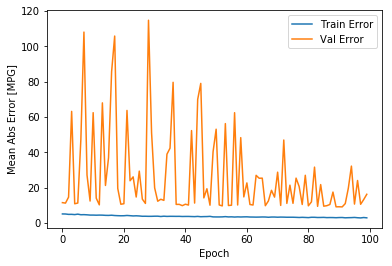

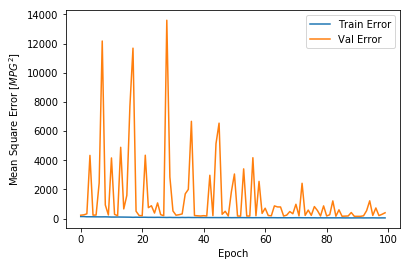

In [261]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

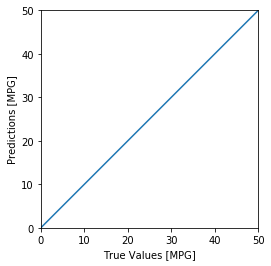

In [262]:
nn_test_predictions = model.predict(test[predictors]).flatten()
nn_train_predictions = model.predict(train[predictors]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_target, nn_test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [263]:
print(mean_absolute_error(train_target, nn_train_predictions))
print(mean_absolute_error(test_target, nn_test_predictions))

5.640697649710364
21.478339975662685
